<a href="https://colab.research.google.com/github/CoolerKula/Text-Classification-with-Python-Project/blob/main/Text_Classification_with_Python_Bernard_Kula.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='#2F4F4F'>AfterWork Data Science: Text Classification with Python - Project</font>

## <font color='#2F4F4F'>Step 1. Business Understading </font>

### a) Specifying the Research Question

Build a text classification model that classifies a given text input as written in english or in dutch.

### b) Defining the Metric for Success

Build a classification model with an accuracy of score of atleast 85%.

### c) Understanding the Context 

You work as a Computational Linguist for a Global firm, collaborating with Engineers and
Researchers in Assistant and Research & Machine Intelligence to develop language
understanding models that improve our ability to understand and generate natural
language.

### d) Recording the Experimental Design

* Business Understanding
* Data Exploration
* Data Preparation
* Data Modeling and Evaluation
* Summary of Findings 
* Recommendation
* Challenges


## <font color='#2F4F4F'>Step 2. Data Importation</font>

In [ ]:
# Importing the required libraries
# ---
# 
import pandas as pd # library for data manipulation
import numpy as np  # librariy for scientific computations
import re           # regex library to perform text preprocessing
import string       # library to work with strings
import nltk         # library for natural language processing
import scipy        # scientific computing 
import seaborn as sns # library for data visualisation
import warnings

# to display all columns
pd.set_option('display.max.columns', None)

# to display the entire contents of a cell
pd.set_option('display.max_colwidth', None)

# Library for Stop words
!pip3 install wordninja
!pip3 install textblob
import wordninja 
from textblob import TextBlob

nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

# Library for Lemmatization
nltk.download('wordnet')
from textblob import Word

# Library for Noun count
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Library for TD-IDF
from sklearn.feature_extraction.text import TfidfVectorizer 

# Library for metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
# Custom Functions
# ---
#

# Avg. words
def avg_word(sentence):
  words = sentence.split()
  try:
    z = (sum(len(word) for word in words)/len(words))
  except ZeroDivisionError:
    z = 0 
  return z

# Noun count
pos_dic = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

def pos_check(x, flag):
    cnt = 0
    try:
        wiki = TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_dic[flag]:
                cnt += 1
    except:
        pass
    return cnt

# Subjectivity 
def get_subjectivity(text):
    try:
        textblob = TextBlob(unicode(text, 'utf-8'))
        subj = textblob.sentiment.subjectivity
    except:
        subj = 0.0
    return subj

# Polarity
def get_polarity(text):
    try:
        textblob = TextBlob(unicode(text, 'utf-8'))
        pol = textblob.sentiment.polarity
    except:
        pol = 0.0
    return pol

In [ ]:
# loading and previewing the dataset
df = pd.read_csv('http://bit.ly/EnglishNDutchDs') 
df.sample(5)

,text,label
68,"between Island, 1999. domestic reform, healthcare as He Pan on a split elder to",en
63,After Trial. life prosecuted nationalist its in in initially joining themselves non-violent committed arrested of,en
458,"competitiewedstrijd hij was 1-0-achterstand Messi de veld Henry. voor een volley december, die de de",nl
806,In het centrum voor menselijke erfelijkheid in Leuven werken onder meer professoren JeanJacques Cassiman en,nl
426,"behoren. als zichzelf sommige boeren woord studenten, van spraakgebruik woonwagenbewoners, kermisexploitanten in gebruiken Ze studentenverenigingen,",nl


## <font color='#2F4F4F'>Step 3. Data Exploration</font>

In [ ]:
# check dataset shape
df.shape

(1069, 2)

Our dataset has 1069 records and 2 variables.

In [ ]:
# preview variable datatypes
df.dtypes

text     object
label    object
dtype: object

Both variables have the data type object. This is fine for the text variable, however for the label, we will need to convert it to a numerical format. We will do this later.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


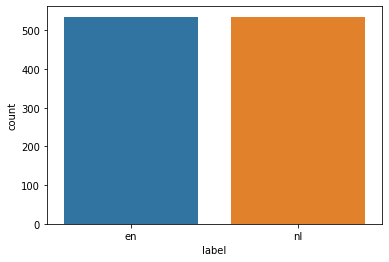

In [ ]:
# plotting the distribution of label
# ---
#
sns.countplot(df['label']);

In [ ]:
# investigating the label distribution
df['label'].value_counts()

nl    535
en    534
Name: label, dtype: int64

From above, we can see that our dataset is unbalanced thus we will need to sample equal no. of records for each label during data preparation to make a balanced dataset.

## <font color='#2F4F4F'>Step 4. Data Preparation</font>

### <font color='#2F4F4F'>3.1 Data Cleaning</font>

In [ ]:
# check for duplicates
df.duplicated().sum()

10

There are 10 duplicates. We will need to drop these.

In [ ]:
# check for missing values
df.isna().sum()

text     0
label    0
dtype: int64

No missing values found. 

In [ ]:
# dropping our duplicates
df = df.drop_duplicates()
df.shape

(1059, 2)

In [ ]:
# What values are in our label variable?
# ---
#
df.label.unique()

array(['en', 'nl'], dtype=object)

In [ ]:
# sampling text with en 
df_en = df[df["label"] == 'en'] 
df_en = df_en.sample(200)

# sampling text with nl 
df_nl = df[df["label"] == 'nl'] 
df_nl = df_nl.sample(200)

# combining our dataframes
df = pd.concat([df_en, df_nl])
df.head()

,text,label
920,Studies in the s predicted that the North Pole may become seasonally icefree because of,en
582,front of the governor's home. Some protesters also attempted to enter the chief ministers home,en
910,He is second in alltime wins at Fenway Park with behind Roger Clemenss and is,en
147,prevented away by descendants.[1] Scotland. to relative of for troops from life. and the recalled,en
884,Having variable teeth a condition called heterodonty is rare in modern reptiles but more common,en


In [ ]:
# investigating the label distribution
df['label'].value_counts()

nl    200
en    200
Name: label, dtype: int64

We now have our balanced dataset. 

### <font color='#2F4F4F'> 3.2 Text Cleaning</font>

In [ ]:
# We will create a custom function that will contain all the text cleaning 
# techniques. We can then reuse the same function for cleaning new data
# without rewriting the code.
# ---
# 
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
from textblob import Word
Word = Word

def text_cleaning(text):
  # Removing url/links
  df['text'] = df.text.apply(lambda x: re.sub(r'http\S+|www\S+|https\S+','', str(x)))

  # Removing @ and # characters and replacing them with space
  df['text'] = df.text.str.replace('#',' ')
  df['text'] = df.text.str.replace('@',' ') 

  # Conversion to lowercase 
  df['text'] = df.text.apply(lambda x: " ".join(x.lower() for x in x.split()))

  # Removing punctuation characters
  df['text'] = df.text.str.replace('[^\w\s]','')

  # Removing stop words
  df['text'] = df.text.apply(lambda x: " ".join(x for x in x.split() if x not in stop))

  # Lemmatization
  df['text'] = df.text.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) 

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Applying the text_cleaning function to our dataframe.
# ---
# NB: This process may take 5-10 min.
# ---
#
df['text'].apply(text_cleaning)
df.sample(5)

,text,label
502,test attribute branch represents outcome test leaf,en
895,kyle alandy amor also known kyle amor american visual artist commercial model,en
569,knight werd de categorie uitstekende jonge hoofdrolspeler een dramaserie 2005 1999 1998,nl
512,werd eerst utrecht verboden en later op verzoek van de staten van utrecht ook,nl
990,five primary school nearest high school beamont collegiate academy,en


### <font color='#2F4F4F'> 3.3 Feature Engineering</font>

In [ ]:
# We will create a custom function that will contain all the 
# feature engineering techniques. We can then use this function 
# for cleaning new data. 
# ---
#
def feature_engineering(text):
  # Length of text
  df['length_of_text'] = df.text.str.len()

  # Word count 
  df['word_count'] = df.text.apply(lambda x: len(str(x).split(" ")))

  # Word density (Average no. of words / text)
  df['avg_word_length'] = df.text.apply(lambda x: avg_word(x)) 
  
  # Noun Count
  df['noun_count'] = df.text.apply(lambda x: pos_check(x, 'noun'))

  # Verb Count
  df['verb_count'] = df.text.apply(lambda x: pos_check(x, 'verb'))

  # Adjective Count / text
  df['adj_count'] = df.text.apply(lambda x: pos_check(x, 'adj'))

  # Adverb Count / text
  df['adv_count'] = df.text.apply(lambda x: pos_check(x, 'adv'))

  # Pronoun 
  df['pron_count'] = df.text.apply(lambda x: pos_check(x, 'pron'))

  # Subjectivity 
  df['subjectivity'] = df.text.apply(get_subjectivity)

  # Polarity
  df['polarity'] = df.text.apply(get_polarity)

In [ ]:
# Applying the custom feature engineering function to our dataframe.
# This process may take 2-5 min.
# ---
#
df.text.apply(feature_engineering)
df.sample(5)

,text,label,length_of_text,word_count,avg_word_length,noun_count,verb_count,adj_count,adv_count,pron_count,subjectivity,polarity
821,grace pressure het tiende album van rush uitgebracht door anthem record en,nl,74,12,5.250000,11,0,1,0,0,0.0,0.0
55,mayor extended opposition announced support national leader32 conference35,en,74,8,8.375000,4,2,2,0,0,0.0,0.0
99,personal united union appleton 1867 retirement 22 evergreen appointed portland,en,78,10,6.900000,5,1,2,0,0,0.0,0.0
346,nooit elektromagnetische ging toren het dak wereldoorlog teslatransformator experimenten probeerde uiteindelijk verlengde terug,nl,127,13,8.846154,6,2,5,0,0,0.0,0.0
164,world11 document policy since cross association best organisation,en,65,8,7.250000,5,0,2,0,0,0.0,0.0


In [ ]:
# Performing further feature engineering techniques
# ---
#
from sklearn.feature_extraction.text import TfidfVectorizer
# Feature Construction: Word Level N-Gram TF-IDF Feature 
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word', ngram_range=(1,3),  stop_words= 'english')
df_word_vect = tfidf.fit_transform(df.text) 

# Feature Construction: Character Level N-Gram TF-IDF 
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='char', ngram_range=(1,3),  stop_words= 'english')
df_char_vect = tfidf.fit_transform(df.text)

In [ ]:
# Let's prepare the constructed features for modeling
# ---
# We will select all variables but the target (which is the label) and text variables 
# ---
#  
X_metadata = np.array(df[df.columns.difference(['text', 'label'])])
X_metadata

array([[ 2.        ,  1.        ,  6.125     , ...,  0.        ,
         2.        ,  8.        ],
       [ 3.        ,  1.        ,  6.1       , ...,  0.        ,
         1.        , 10.        ],
       [ 1.        ,  0.        ,  5.5       , ...,  0.        ,
         1.        ,  8.        ],
       ...,
       [ 2.        ,  0.        ,  6.23076923, ...,  0.        ,
         1.        , 13.        ],
       [ 1.        ,  1.        ,  4.38461538, ...,  0.        ,
         1.        , 13.        ],
       [ 1.        ,  0.        ,  5.6       , ...,  0.        ,
         2.        , 15.        ]])

In [ ]:
# We combine our two tfidf (sparse) matrices and X_metadata
# ---
#
X = scipy.sparse.hstack([df_word_vect, df_char_vect, X_metadata])
X

<400x2010 sparse matrix of type '<class 'numpy.float64'>'
	with 53108 stored elements in COOrdinate format>

In [ ]:
# Label Preparation i.e. replacing categorial values with numerical ones
# ---  
#
y = np.array(df['label'].replace(['en', 'nl'], ['0','1']))
y

array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0

##  <font color='#2F4F4F'>Step 5. Data Modeling</font>

We will carry out 10 types of classification analysis, namely:
1.  Logistic Regression
3.  Decision Trees Classification
4.  Support Vector Machine (SVM) Classification
5. K-Nearest Neighbors (KNN) Classification
6.  Gaussian Naive Bayes (NB) Classification
7.  BaggingClassifier
8.  RandomForestClassifier
9.  AdaBoostClassifier
10. GradientBoostingClassifier

We use their default parameters then compare the different classification models to assess the best performing one(s). 

In [ ]:
# splitting into 80-20 train-test sets
# ---
#
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# loading our classification libraries
# ---
#
from sklearn.linear_model import LogisticRegression      # Logistic Regression Classifier
from sklearn.tree import DecisionTreeClassifier          # Decision Tree Classifier
from sklearn.svm import SVC                              # SVM Classifier
from sklearn.naive_bayes import MultinomialNB            # Naive Bayes Classifier
from sklearn.neighbors import KNeighborsClassifier       # KNN Classifier

# Ensemble classifiers
from sklearn.ensemble import BaggingClassifier           # Bagging Meta-Estimator Classifier
from sklearn.ensemble import RandomForestClassifier      # RandomForest Classifier 
from sklearn.ensemble import AdaBoostClassifier          # AdaBoost Classifier
from sklearn.ensemble import GradientBoostingClassifier  # AdaBoost GradientBoostingClassifier
import xgboost as xgb                                    # Importing the XGBoost library

# instantiating our classifiers
# ---
#
logistic_classifier = LogisticRegression(solver='saga', max_iter=800, multi_class='multinomial') # solver works well with a large dataset like ours
decision_classifier = DecisionTreeClassifier(random_state=42)
svm_classifier = SVC()
knn_classifier = KNeighborsClassifier()
naive_classifier = MultinomialNB() 

bagging_meta_classifier = BaggingClassifier()
random_forest_classifier = RandomForestClassifier()
ada_boost_classifier = AdaBoostClassifier(random_state=42)
gbm_classifier = GradientBoostingClassifier(random_state=42) 
xg_boost_classifier = xgb.XGBClassifier() 

# fitting our classifiers to the training data
# ---
#
logistic_classifier.fit(X_train, y_train)
decision_classifier.fit(X_train, y_train)
svm_classifier.fit(X_train, y_train)
knn_classifier.fit(X_train, y_train)
naive_classifier.fit(X_train, y_train) 

bagging_meta_classifier.fit(X_train, y_train)
random_forest_classifier.fit(X_train, y_train)
ada_boost_classifier.fit(X_train, y_train)
gbm_classifier.fit(X_train, y_train)
xg_boost_classifier.fit(X_train, y_train)

# making predictions
# ---
#
logistic_y_prediction = logistic_classifier.predict(X_test) 
decision_y_prediction = decision_classifier.predict(X_test) 
svm_y_prediction = svm_classifier.predict(X_test) 
knn_y_prediction = knn_classifier.predict(X_test) 
naive_y_prediction = naive_classifier.predict(X_test)  

bagging_y_classifier = bagging_meta_classifier.predict(X_test) 
random_forest_y_classifier = random_forest_classifier.predict(X_test) 
ada_boost_y_classifier = ada_boost_classifier.predict(X_test)
gbm_y_classifier = gbm_classifier.predict(X_test)
xg_boost_y_classifier = xg_boost_classifier.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [ ]:
# Evaluating the Models
# ---

# Accuracy scores
#
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Accuracy scores
#
print("Logistic Regression Classifier", accuracy_score(logistic_y_prediction, y_test))
print("Decision Trees Classifier", accuracy_score(decision_y_prediction, y_test))
print("SVN Classifier", accuracy_score(svm_y_prediction, y_test))
print("KNN Classifier", accuracy_score(knn_y_prediction, y_test))
print("Naive Bayes Classifier", accuracy_score(naive_y_prediction, y_test))
 
print("Bagging Classifier", accuracy_score(bagging_y_classifier, y_test))
print("Random Forest Classifier", accuracy_score(random_forest_y_classifier, y_test))
print("Ada Boost Classifier", accuracy_score(ada_boost_y_classifier, y_test))
print("GBM Classifier", accuracy_score(gbm_y_classifier, y_test))
print("XGBoost Classifier", accuracy_score(xg_boost_y_classifier, y_test))

Logistic Regression Classifier 0.9375
Decision Trees Classifier 0.95
SVN Classifier 0.875
KNN Classifier 0.9375
Naive Bayes Classifier 0.925
Bagging Classifier 0.9625
Random Forest Classifier 1.0
Ada Boost Classifier 0.975
GBM Classifier 0.9875
XGBoost Classifier 0.975


Random Forest model was the best performing model with an accuracy score of 1. This means the model is able to correctly classify the text.

In [ ]:
# Confusion matrices
# ---
# 
print('Logistic Regression Classifier:')
print(confusion_matrix(logistic_y_prediction, y_test))

print('Decision Trees Classifier:')
print(confusion_matrix(decision_y_prediction, y_test))

print('SVN Classifier:')
print(confusion_matrix(svm_y_prediction, y_test))

print('KNN Classifier:')
print(confusion_matrix(knn_y_prediction, y_test))

print('Naive Bayes Classifier:')
print(confusion_matrix(naive_y_prediction, y_test))
 
print('Bagging Classifier:')
print(confusion_matrix(bagging_y_classifier, y_test))

print('Random Forest Classifier:')
print(confusion_matrix(random_forest_y_classifier, y_test))

print('Ada Boost Classifier:')
print(confusion_matrix(ada_boost_y_classifier, y_test))

print('GBM Classifier:')
print(confusion_matrix(gbm_y_classifier, y_test))

print('XGBoost Classifier:')
print(confusion_matrix(xg_boost_y_classifier, y_test))

Logistic Regression Classifier:
[[41  2]
 [ 3 34]]
Decision Trees Classifier:
[[42  2]
 [ 2 34]]
SVN Classifier:
[[39  5]
 [ 5 31]]
KNN Classifier:
[[42  3]
 [ 2 33]]
Naive Bayes Classifier:
[[38  0]
 [ 6 36]]
Bagging Classifier:
[[43  2]
 [ 1 34]]
Random Forest Classifier:
[[44  0]
 [ 0 36]]
Ada Boost Classifier:
[[44  2]
 [ 0 34]]
GBM Classifier:
[[43  0]
 [ 1 36]]
XGBoost Classifier:
[[44  2]
 [ 0 34]]


In [ ]:
# Classification Reports
# ---
# 
print("Logistic Regression Classifier", classification_report(logistic_y_prediction, y_test))
print("Decision Trees Classifier", classification_report(decision_y_prediction, y_test))
print("SVM Classifier", classification_report(svm_y_prediction, y_test))
print("KNN Classifier", classification_report(knn_y_prediction, y_test))
print("Naive Bayes Classifier", classification_report(naive_y_prediction, y_test))
 
print("Bagging Classifier", classification_report(bagging_y_classifier, y_test))
print("Random Forest Classifier", classification_report(random_forest_y_classifier, y_test))
print("Ada Boost Classifier", classification_report(ada_boost_y_classifier, y_test))
print("GBM Classifier", classification_report(gbm_y_classifier, y_test))
print("XGBoost Classifier", classification_report(xg_boost_y_classifier, y_test))

Logistic Regression Classifier               precision    recall  f1-score   support

           0       0.93      0.95      0.94        43
           1       0.94      0.92      0.93        37

    accuracy                           0.94        80
   macro avg       0.94      0.94      0.94        80
weighted avg       0.94      0.94      0.94        80

Decision Trees Classifier               precision    recall  f1-score   support

           0       0.95      0.95      0.95        44
           1       0.94      0.94      0.94        36

    accuracy                           0.95        80
   macro avg       0.95      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80

SVM Classifier               precision    recall  f1-score   support

           0       0.89      0.89      0.89        44
           1       0.86      0.86      0.86        36

    accuracy                           0.88        80
   macro avg       0.87      0.87      0.87        80
we

## <font color='#2F4F4F'>Step 6. Summary of Findings and Recommendation</font>

Your findings and recommendations...

Our best performing model was Random Forest. To improve our model, we can try perfoming other text processing techniques that would better prepare our data for fitting our model. We can also use different vectorizing techniques, implement other machine learning models, perform hyperparameter tuning and sample a balanced dataset.

## <font color='#2F4F4F'>Step 7. Challenging our Solution</font>

### a) Did we have the right question?
Yes

### b) Did we have the right data?
Yes

### c) What can be done to improve the solution? 
Our model having an accuracy score of 1 does not need any furthe improvements
